<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/250px-Jupyter_logo.svg.png" alt="Jupyter_logo" class="img-rounded img-responsive" height="60" width="60" align="left">
<span><br><br><br></span>

<h1 align='center' style='margin-bottom: 0px'>基于客户购买记录的客户细分</h1>

***
## 目的&总览
> 数据集包含很多客户针对不同类型产品的年度批发采购金额。  
> 分析的目的是更好地描述批发商各客户之间的差异，利用分析更好地组织他们的物流服务和商品需求以满足每个客户的需求。 

过程总览如下：
> 数据探索  
> 数据预处理  
> 使用模型  
> 可视化结果  
***

In [1]:
#导入使用的包
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visuals  as vs   #自定义可视化包
sns.set(style="whitegrid")
%matplotlib inline

## 数据探索

In [2]:
data = pd.read_csv("G:/project/MLND-Customer-Segmentation-master/customers.csv")
print("本数据集共有%d行数据："%data.shape[0])
data.head()

本数据集共有440行数据：


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
#Channel和Region本次分析不使用，只选取各商品字段
data = data.iloc[:,2:]
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [4]:
data.isnull().sum()
#该组数据没有缺失值

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

> 下面箱线图和散点图可以看出，每个数据极均有极大异常值，散点图似乎看不出有什么规律

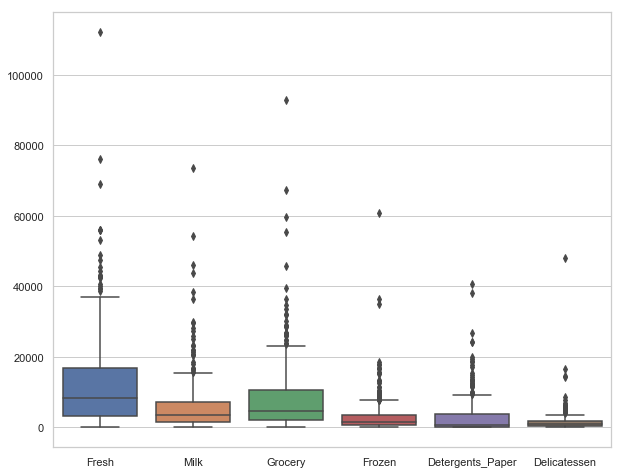

In [5]:
plt.figure(figsize=(10,8))
sns.boxplot(data=data)
plt.show()

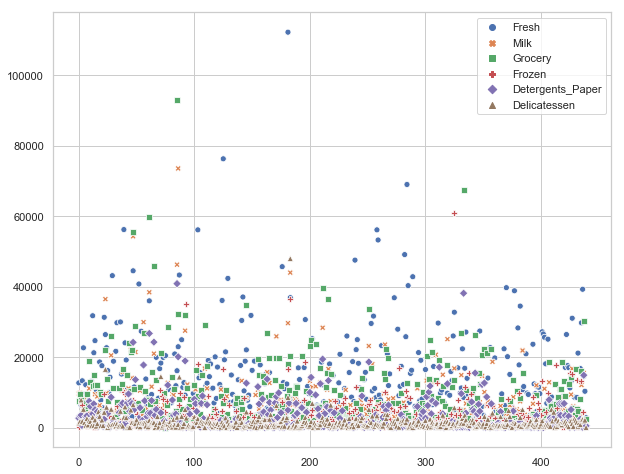

In [6]:
plt.figure(figsize=(10,8))
sns.scatterplot(hue=data.columns, data=data)
plt.show()

> 下图可以看出grocery和Detergents_paper、grocery和Milk彼此之间有一定的相关性，数据非正态分布，大部分集中在数值较小区域。

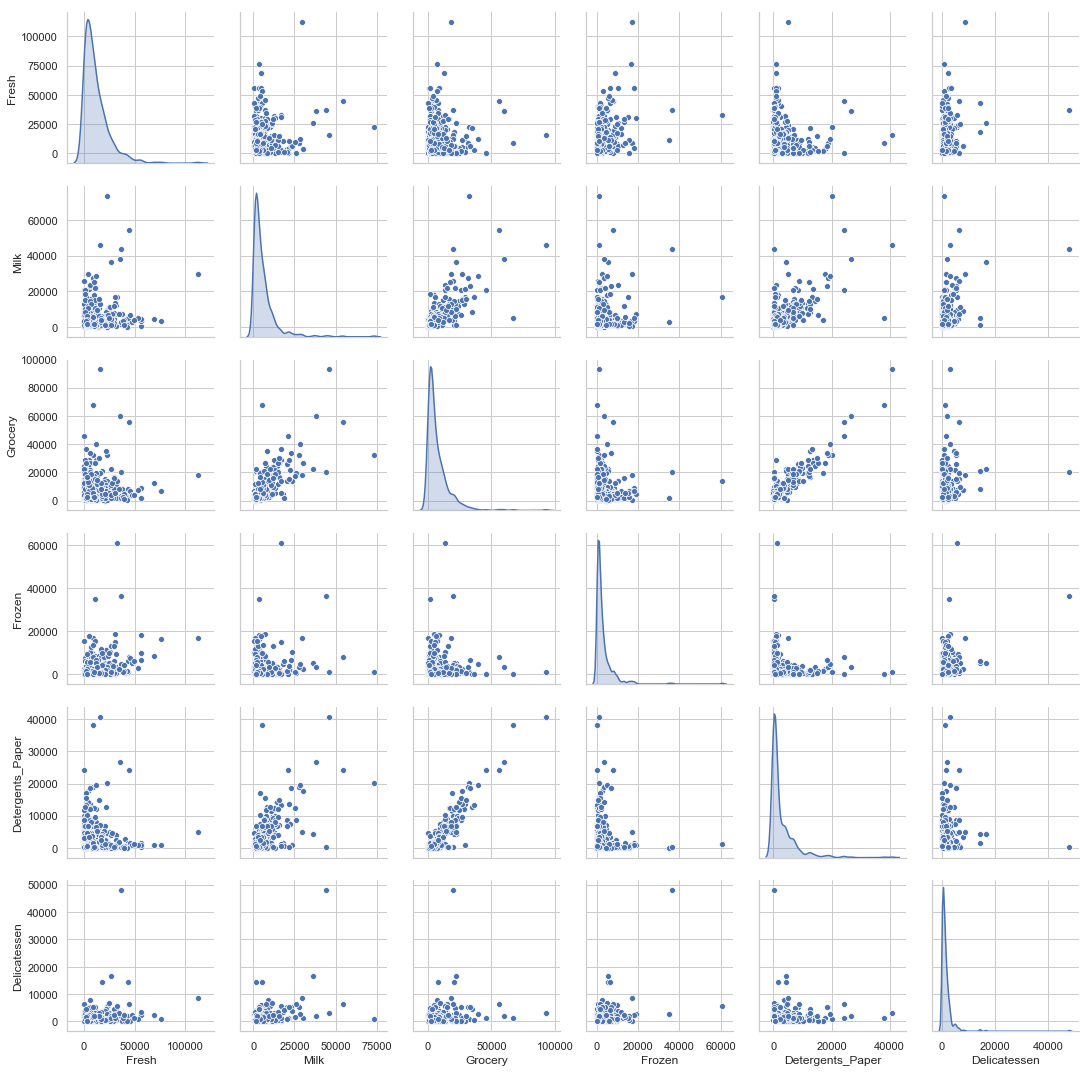

In [7]:
sns.pairplot(data,diag_kind="kde")
plt.show()

## 数据预处理

- 特征缩放：使用'box-cox/yeo-johnson变换'使数据服从正态分布

In [8]:
from sklearn.preprocessing import power_transform
stdata = power_transform(data, method='yeo-johnson')
stdata = pd.DataFrame(stdata,columns  = data.columns)

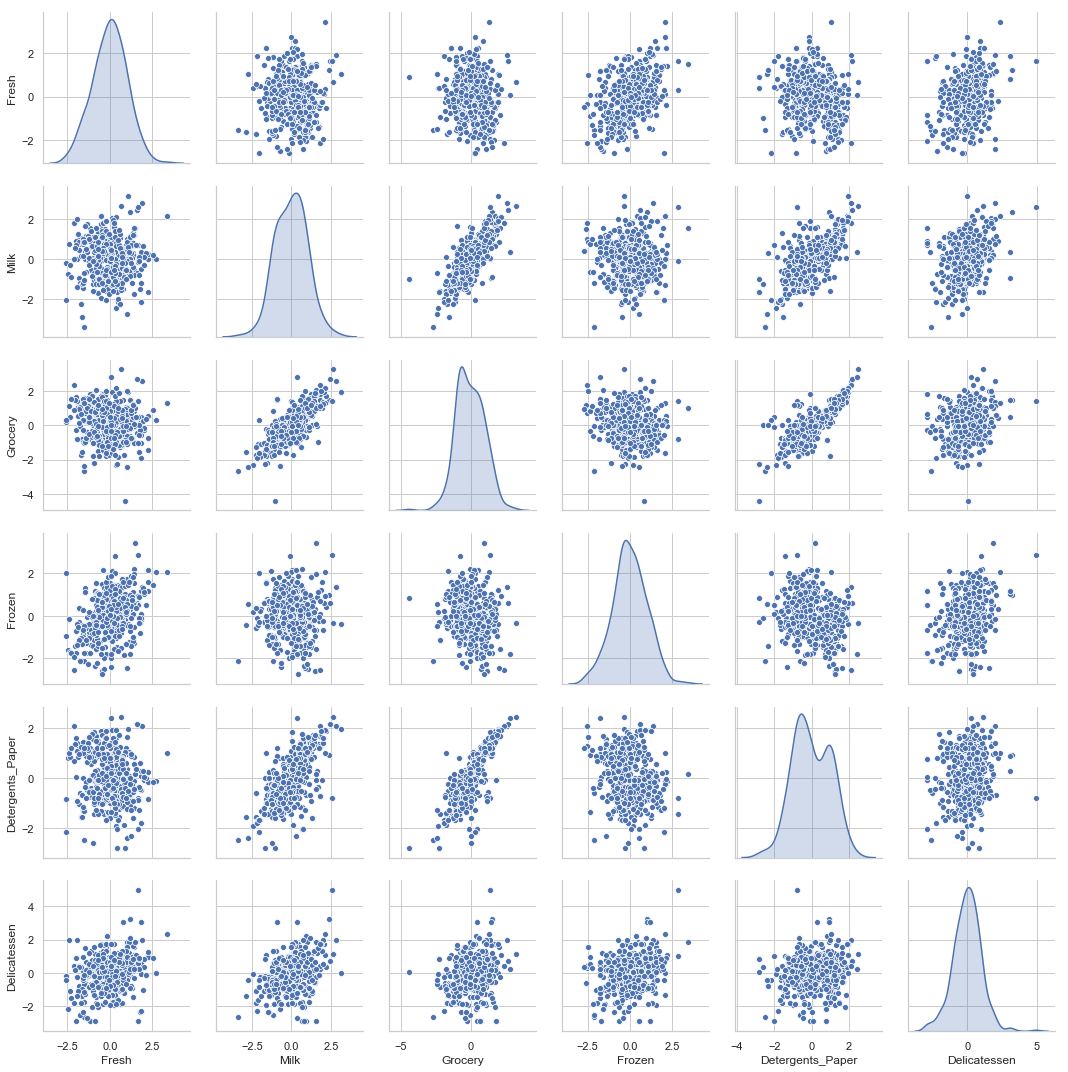

In [9]:
sns.pairplot(stdata,diag_kind="kde")
plt.show()

- 异常值处理：从箱形图看出每类均有极大值异常点

In [10]:
from collections import Counter
def detect_outliers(df):
    outlier_indices = []
    for col in df.columns:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        print(col,"列的异常值：")
        display(df.iloc[outlier_list_col,:])
        
    outlier_indices = Counter(outlier_indices) #列出每个index出现的个数
    multiple_outliers = list( k for k, v in outlier_indices.items() if v >=2)#出现2次的index
    print("出现2次及以上异常值的index：",multiple_outliers)
    #丢弃该异常值
    df.drop(index =multiple_outliers,inplace=True)

In [11]:
detect_outliers(stdata)

Fresh 列的异常值：


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
181,3.393795,2.140156,1.298736,2.073491,1.012211,2.349651


Milk 列的异常值：


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,1.044641,3.146213,1.942896,-0.37199,1.954921,-0.006368
154,-1.534163,-3.372439,-2.691232,-2.11921,-2.489526,-2.625701


Grocery 列的异常值：


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,0.911385,-1.009163,-4.398854,0.844249,-2.797946,0.058867
85,0.656161,2.624480,3.268233,-0.342480,2.461726,1.109616


Frozen 列的异常值：


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,-0.442226,1.474024,1.209207,-2.590759,1.234834,-0.586249
57,-0.319668,1.007688,0.721188,-2.512669,1.290951,0.299389
65,-2.136759,1.772562,2.367877,-2.542744,2.087447,0.394346
93,0.304568,-0.114941,-0.778025,2.817201,-1.429777,1.018578
145,0.999157,0.839240,2.036993,-2.456521,1.632855,1.556135
183,1.635784,2.569404,1.414556,2.861692,-0.791993,4.954018
325,1.479855,1.541043,0.992048,3.407522,0.165222,1.829839
420,-0.463707,0.386794,0.960861,-2.740748,1.221621,0.374806


Detergents_Paper 列的异常值：


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen


Delicatessen 列的异常值：


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,1.210672,2.363537,1.511879,0.981063,0.927193,3.247979
71,0.791055,-0.915882,1.461388,1.017742,0.902445,3.058333
87,1.855251,0.341988,0.464556,1.160985,0.295766,3.046475
109,-1.164444,1.537648,1.823856,-0.658171,-0.083721,-2.896435
128,-2.017449,0.892443,-0.244239,-1.724507,0.057480,-2.896435
142,1.642618,0.683042,0.480956,0.514728,-2.039898,-2.896435
154,-1.534163,-3.372439,-2.691232,-2.119210,-2.489526,-2.625701
183,1.635784,2.569404,1.414556,2.861692,-0.791993,4.954018
184,-1.768924,-1.192876,-0.054392,-2.127249,-0.607678,-2.519447
187,-0.859630,0.793238,0.654475,1.154864,0.782726,-2.896435


出现2次及以上异常值的index： [154, 183]


- PCA降维

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
re_data = pca.fit_transform(stdata)

re_data =pd.DataFrame(re_data, columns = ['Dimension 1', 'Dimension 2'])

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4524,0.1279,-0.5308,-0.5705,0.1651,-0.5543,-0.2047
Dimension 2,0.2709,0.6059,0.1474,0.0321,0.5831,-0.0517,0.5171


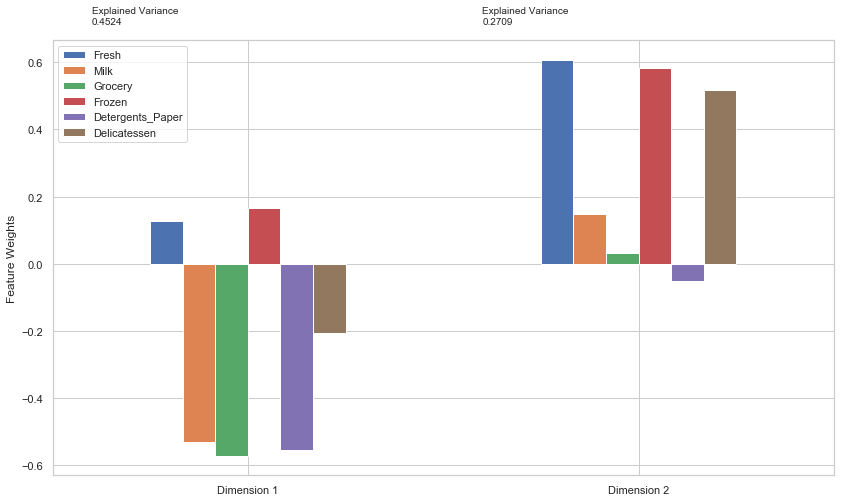

In [13]:
#生成PCA结果图
vs.pca_results(stdata,pca)

> 从图中可以看出2个维度中：  
> ①Grocery，Milk，Detegrents_paper方差贡献最大,猜可能是一些便利店    
> ②Fresh,Frozen,Delicatessen方差贡献最大,猜可能是一些生鲜和熟食店

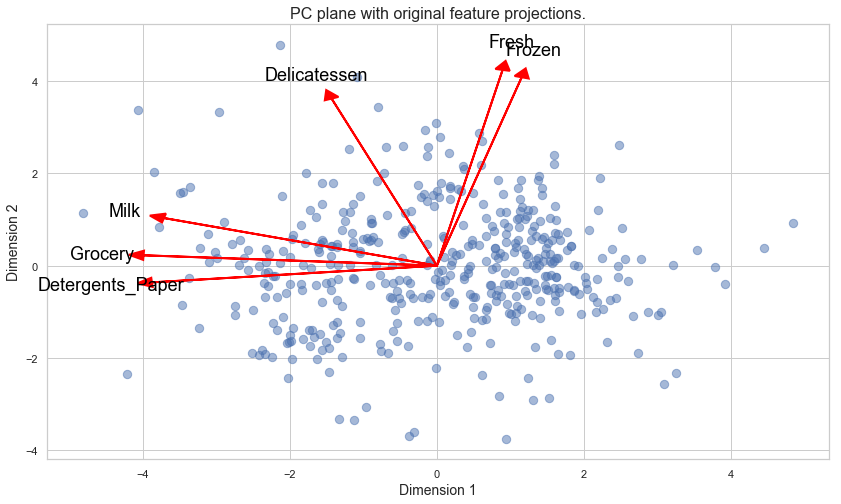

In [14]:
vs.biplot(stdata, re_data, pca)
plt.show()

## 模型选择
主要的聚类分析有Kmeans和高斯混合模型（GMM）两种~

- Kmeans模型

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

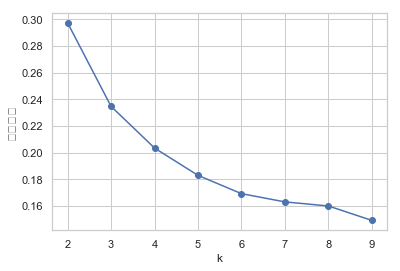

In [16]:
num_clusters = np.arange(2,10)
Scores = []
for k in num_clusters:
    kmodel = KMeans(n_clusters = k,n_jobs = 4).fit(re_data)
    #y_pred = kmodel.labels_   #各样本对应类别
    #pre = kmodel.fit_predict(stdata)
    Scores.append(silhouette_score(stdata,kmodel.labels_,metric='euclidean'))
X = range(2,10)  
plt.xlabel('k')  
plt.ylabel('轮廓系数')      
plt.plot(X,Scores,'o-')  
plt.show()

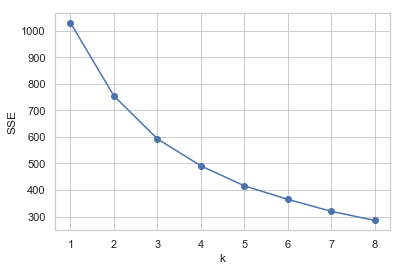

In [17]:
SSE = []  # 存放每次结果的误差平方和
for k in range(2,10):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(re_data)
    SSE.append(estimator.inertia_)
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')

综合以上结果，轮廓系数最大的k值是2，这表示我们的最佳聚类数为2

In [18]:
kmodel = KMeans(n_clusters = 2,n_jobs = 4).fit(re_data)
y_pred = kmodel.labels_   #各样本对应类别的数目
kmeans_pre = kmodel.fit_predict(re_data)#返回每个数据对应的标签，并将标签值对应到相应的簇(和上面一样)
kmeans_center  = kmodel.cluster_centers_

- 高斯混合模型

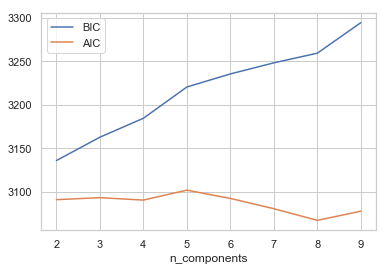

In [19]:
from sklearn.mixture import GaussianMixture
n_components = np.arange(2, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(re_data) for n in n_components]
#使用AIC和BIC函数确定中心个数，最佳的聚类数目是使得AIC或BIC最小化的值
plt.plot(n_components, [m.bic(re_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(re_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

- 貌似2，3都是不错的选择

In [20]:
gmmmodels = GaussianMixture(2, covariance_type='full', random_state=0).fit(re_data)
gmm_pre = gmmmodels.predict(re_data)
gmm_center = gmmmodels.means_

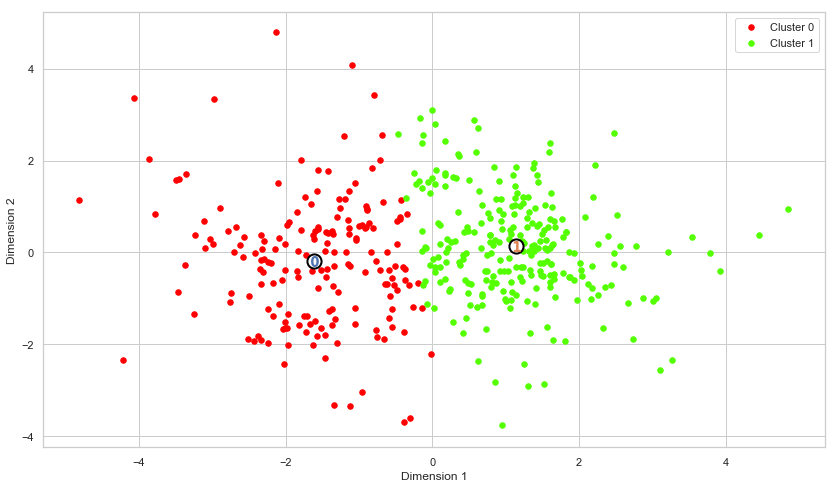

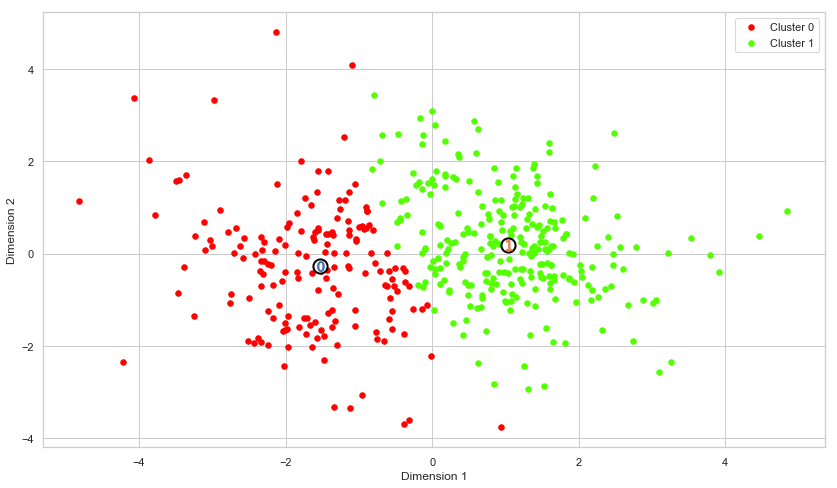

In [21]:
vs.cluster(re_data, kmeans_pre, kmeans_center)
vs.cluster(re_data, gmm_pre, gmm_center)

> 可见使用Kmeans和高斯混合模型在聚类的结果上大致相同，但GMM可以衡量每个点属于给定类别的概率

In [22]:
#高斯混合模型标签结果
pd.DataFrame(gmmmodels.predict_proba(re_data),columns=['cluster0','cluster1']).head()

,cluster0,cluster1
0,0.933214,0.066786
1,0.902619,0.097381
2,0.883889,0.116111
3,0.016096,0.983904
4,0.411141,0.588859


In [23]:
#kmeans标签结果
kdata = pd.DataFrame(kmodel.predict(re_data),columns = ['cluster'])
kdata.head()

,cluster
0,0
1,0
2,0
3,1
4,0


## 可视化结果

In [24]:
fdata = kdata.join(data.drop(index=[154,183]))
fdata.head()

,cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,0,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
2,0,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0
3,1,13265.0,1196.0,4221.0,6404.0,507.0,1788.0
4,0,22615.0,5410.0,7198.0,3915.0,1777.0,5185.0


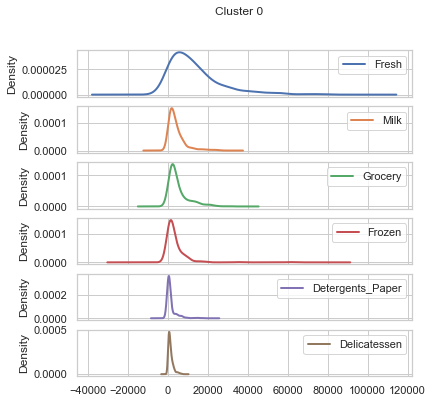

In [25]:
plt.style.use({'figure.figsize':(6, 6)}) 
fdata[fdata['cluster']==1].drop('cluster',axis=1).plot(kind='kde',title = 'Cluster 0',linewidth=2,subplots=True,sharex =True)
plt.show()

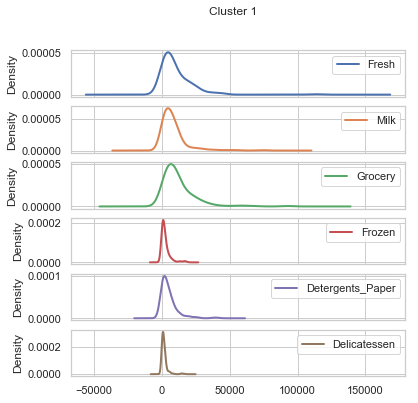

In [26]:
plt.style.use({'figure.figsize':(6, 6)}) 
fdata[fdata['cluster']==0].drop('cluster',axis=1).plot(kind='kde',title = 'Cluster 1',linewidth=2,subplots=True,sharex =True)
plt.show()

结论：
- cluster1在牛奶、杂货、清洁剂和纸张等类别中采购量高。这些客户可能是零售连锁店和杂货便利店。
- cluster0大多数采购都是新鲜食品和冷冻类，这表明这一部分可能是准备和烹饪食物的餐馆。